In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir 'pretrained'
!cp '/content/gdrive/MyDrive/visual-product-recognition-pre-trained/model1.pt' '/content/pretrained/'
!cp '/content/gdrive/MyDrive/visual-product-recognition-pre-trained/model2.pt' '/content/pretrained/'
!cp '/content/gdrive/MyDrive/visual-product-recognition-pre-trained/model3.pt' '/content/pretrained/'

In [3]:
%%capture
!unzip /content/gdrive/MyDrive/test-archive.zip -d /content/testing-dataset

In [4]:
!mv "/content/testing-dataset/development_test_data/gallery" "/content/"
!mv "/content/testing-dataset/development_test_data/queries" "/content/"

In [5]:
!mkdir "/content/original_datasets"
!mv "/content/testing-dataset/development_test_data/gallery.csv" "/content/original_datasets/"
!mv "/content/testing-dataset/development_test_data/queries.csv" "/content/original_datasets/"

In [6]:
!rm -rf "/content/testing-dataset"

In [7]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00


In [8]:
import os
import open_clip
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as T
import torchvision.transforms.functional as F
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [9]:
model = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
model.load_state_dict(torch.load('pretrained/model3.pt'))

<All keys matched successfully>

In [10]:
model

VisionTransformer(
  (patchnorm_pre_ln): Identity()
  (conv1): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-31): 32 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1280, out_features=5120, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
)

In [11]:
model = model.to('cuda')

In [12]:
img_transform = T.Compose([T.Resize(size=(224, 224),
                                    interpolation=T.InterpolationMode.BICUBIC,
                                    antialias=True),
                           T.ToTensor(),
                           T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                                       std=(0.26862954, 0.26130258, 0.27577711))])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, indices, transform=None, target_transform=None, crop_to_bbox=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.indices = indices
        self.transform = transform
        self.target_transform = target_transform
        self.crop_to_bbox = crop_to_bbox

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, self.indices[0]])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, self.indices[1]]
        if self.transform:
            if not self.crop_to_bbox:
              image = self.transform(image)
            else:
              x = self.img_labels.iloc[idx, self.indices[2]]
              y = self.img_labels.iloc[idx, self.indices[3]]
              w = self.img_labels.iloc[idx, self.indices[4]]
              h = self.img_labels.iloc[idx, self.indices[5]]
              image = self.transform(image, x, y, w, h)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, img_path

def image_transformation(image):
    images = img_transform(F.to_pil_image(image))
    return images

def image_transform_with_bbox_crop(image, x, y, w, h):
    images = F.crop(F.to_pil_image(image), y, x, h, w)
    images = img_transform(images)
    return images

In [14]:
gallery = pd.read_csv("original_datasets/gallery.csv")
gallery.head()

,seller_img_id,img_path,product_id
0,0,gallery/ambitious-tough-teal-from-asgard.jpg,5019
1,1,gallery/fine-shrewd-oarfish-of-genius.jpg,5008
2,2,gallery/bold-nickel-gecko-of-reputation.jpg,9
3,3,gallery/marvellous-uber-boobook-of-lightning.jpg,3589
4,4,gallery/bouncy-economic-agama-of-honeydew.jpg,3656


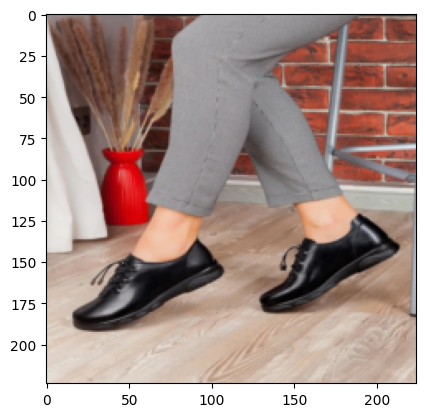

In [15]:
# test image preprocessing
img = read_image(gallery.iloc[0, 1])
img_ = F.to_pil_image(F.resize(img, (224, 224), antialias=True))
plt.imshow(np.asarray(img_))

torch.Size([3, 224, 224])


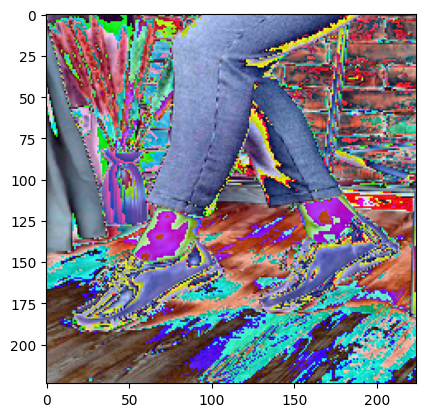

In [16]:
img = read_image(gallery.iloc[0, 1])
proc_img = image_transformation(img)
print(proc_img.shape)
proc_img = F.to_pil_image(proc_img)
plt.imshow(np.asarray(proc_img))

In [17]:
gallery_dataset = CustomDataset("original_datasets/gallery.csv", "", [1, 2], transform=image_transformation)
gallery_dataloader = DataLoader(gallery_dataset, batch_size=32, shuffle=True)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("gallery_tensors"):
    os.makedirs("gallery_tensors")

for idx, data in enumerate(tqdm(gallery_dataloader)):
    images, labels, img_paths = data
    images = images.to('cuda')

    with torch.no_grad():
        output = model(images)
        embeddings = output.cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'gallery_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('gallery_tensors/gallery_tensors.csv', index=False)

100%|██████████| 34/34 [01:46<00:00,  3.13s/it]


In [18]:
class TensorDataset(Dataset):
    def __init__(self, annotations_file, tensor_dir, transform=None, target_transform=None):
        self.tensor_labels = pd.read_csv(annotations_file)
        self.tensor_dir = tensor_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.tensor_labels)

    def __getitem__(self, idx):
        tensor_path = os.path.join(self.tensor_dir, self.tensor_labels.iloc[idx, 1])
        tensor = torch.load(tensor_path)
        label = self.tensor_labels.iloc[idx, 2]
        image_path = self.tensor_labels.iloc[idx, 3]
        if self.transform:
            tensor = self.transform(tensor)
        if self.target_transform:
            label = self.target_transform(label)
        return tensor, label, image_path

In [19]:
gallery_tensors = pd.read_csv("gallery_tensors/gallery_tensors.csv")
gallery_tensors.head()

,index,tensor_path,label,image_path
0,0,gallery_tensors/0_0.pt,5036,gallery/benign-zircon-wapiti-of-fortitude.jpg
1,1,gallery_tensors/0_1.pt,64,gallery/pistachio-bullfrog-of-inescapable-cham...
2,2,gallery_tensors/0_2.pt,5352,gallery/brawny-godlike-prawn-of-speed.jpg
3,3,gallery_tensors/0_3.pt,5178,gallery/mellow-koala-of-stereotyped-essence.jpg
4,4,gallery_tensors/0_4.pt,3679,gallery/hilarious-lush-macaque-of-triumph.jpg


In [20]:
tensor_dataset = TensorDataset("gallery_tensors/gallery_tensors.csv", "")
tensor_dataloader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)

tensor_dict = {}
label_dict = {}
image_path_dict = {}

for idx, data in enumerate(tqdm(tensor_dataloader)):
    tensors, labels, image_paths = data
    tensor_dict[idx] = tensors
    label_dict[idx] = labels
    image_path_dict[idx] = image_paths

100%|██████████| 34/34 [00:00<00:00, 90.96it/s]


In [21]:
query = pd.read_csv("original_datasets/queries.csv")
query.head()

,user_img_id,img_path,bbox_x,bbox_y,bbox_w,bbox_h,product_id
0,0,queries/magnetic-powerful-platypus-of-hail.jpeg,0,212,740,664,5013
1,1,queries/free-keen-mole-of-cookies.jpeg,0,43,714,378,3550
2,2,queries/hilarious-precious-parakeet-of-adverti...,240,310,395,405,71
3,3,queries/optimal-uptight-ringtail-of-cleaning.jpeg,0,242,475,627,3566
4,4,queries/nonchalant-impala-of-fabulous-artistry...,350,125,150,81,5329


In [22]:
query_dataset = CustomDataset("original_datasets/queries.csv", "", [1, 6], transform=image_transformation)
query_dataloader = DataLoader(query_dataset, batch_size=32, shuffle=False)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("query_tensors"):
    os.makedirs("query_tensors")

for idx, data in enumerate(tqdm(query_dataloader)):
    images, labels, img_paths = data
    images = images.to('cuda')

    with torch.no_grad():
        output = model(images)
        embeddings = output.cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'query_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('query_tensors/query_tensors.csv', index=False)

100%|██████████| 61/61 [03:23<00:00,  3.33s/it]


In [23]:
query_tensors = pd.read_csv("query_tensors/query_tensors.csv")
query_tensors.head()

,index,tensor_path,label,image_path
0,0,query_tensors/0_0.pt,5013,queries/magnetic-powerful-platypus-of-hail.jpeg
1,1,query_tensors/0_1.pt,3550,queries/free-keen-mole-of-cookies.jpeg
2,2,query_tensors/0_2.pt,71,queries/hilarious-precious-parakeet-of-adverti...
3,3,query_tensors/0_3.pt,3566,queries/optimal-uptight-ringtail-of-cleaning.jpeg
4,4,query_tensors/0_4.pt,5329,queries/nonchalant-impala-of-fabulous-artistry...


In [24]:
query_dataset = CustomDataset("original_datasets/queries.csv", "", [1, 6, 2, 3, 4, 5], transform=image_transform_with_bbox_crop, crop_to_bbox=True)
query_dataloader = DataLoader(query_dataset, batch_size=32, shuffle=False)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("query_tensors_cropped"):
    os.makedirs("query_tensors_cropped")

for idx, data in enumerate(tqdm(query_dataloader)):
    images, labels, img_paths = data
    images = images.to('cuda')

    with torch.no_grad():
        output = model(images)
        embeddings = output.cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'query_tensors_cropped/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('query_tensors_cropped/query_tensors.csv', index=False)

100%|██████████| 61/61 [03:18<00:00,  3.26s/it]


In [25]:
cropped_query_tensors = pd.read_csv("query_tensors_cropped/query_tensors.csv")
cropped_query_tensors.head()

,index,tensor_path,label,image_path
0,0,query_tensors_cropped/0_0.pt,5013,queries/magnetic-powerful-platypus-of-hail.jpeg
1,1,query_tensors_cropped/0_1.pt,3550,queries/free-keen-mole-of-cookies.jpeg
2,2,query_tensors_cropped/0_2.pt,71,queries/hilarious-precious-parakeet-of-adverti...
3,3,query_tensors_cropped/0_3.pt,3566,queries/optimal-uptight-ringtail-of-cleaning.jpeg
4,4,query_tensors_cropped/0_4.pt,5329,queries/nonchalant-impala-of-fabulous-artistry...


In [26]:
query_tensor_dataset = TensorDataset("query_tensors/query_tensors.csv", "")
query_tensor_dataloader = DataLoader(query_tensor_dataset, batch_size=1, shuffle=False)

query_tensor_dict = {}
query_label_dict = {}
query_image_path_dict = {}

for idx, data in enumerate(tqdm(query_tensor_dataloader)):
    tensors, labels, image_paths = data
    query_tensor_dict[idx] = tensors
    query_label_dict[idx] = labels
    query_image_path_dict[idx] = image_paths

100%|██████████| 1935/1935 [00:00<00:00, 2049.33it/s]


In [27]:
crop_query_tensor_dataset = TensorDataset("query_tensors_cropped/query_tensors.csv", "")
crop_query_tensor_dataloader = DataLoader(crop_query_tensor_dataset, batch_size=1, shuffle=False)

crop_query_tensor_dict = {}
crop_query_label_dict = {}
crop_query_image_path_dict = {}

for idx, data in enumerate(tqdm(crop_query_tensor_dataloader)):
    tensors, labels, image_paths = data
    crop_query_tensor_dict[idx] = tensors
    crop_query_label_dict[idx] = labels
    crop_query_image_path_dict[idx] = image_paths

100%|██████████| 1935/1935 [00:00<00:00, 2016.10it/s]


In [28]:
batch_size = 32

def AP(actual_label, predicted_labels):
    GPTs = predicted_labels.count(actual_label)
    if GPTs < 1:
        return 1
    AP = 0
    GPTs_found = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == actual_label:
            GPTs_found += 1
            AP += GPTs_found / (i + 1)
    return AP / GPTs

def mAP(APs):
    return np.average(APs)

def zero_shot_model(query_tensor_dictionary, query_label_dictionary):
    APs_euclidean = []
    APs_manhattan = []
    APs_cosine = []
    for i in tqdm(range(len(query_tensor_dictionary))):
        query_tensor_ = query_tensor_dictionary[i].to('cuda')
        query_tensor = query_tensor_.repeat(batch_size, 1)

        euclidean = None
        manhattan = None
        cosine = None
        pred_labels = None
        act_label = query_label_dictionary[i]
        for k in range(len(tensor_dict)):
            if tensor_dict[k].shape[0] < batch_size:
                query_tensor = query_tensor_.repeat(tensor_dict[k].shape[0], 1)
            gallery_tensors = tensor_dict[k].to('cuda')
            gallery_labels = label_dict[k].to('cuda')
            if euclidean == None and manhattan == None and cosine == None:
                euclidean = torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=2)
                manhattan = torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=1)
                cosine = torch.nn.functional.cosine_similarity(gallery_tensors, query_tensor)
                pred_labels = gallery_labels
            else:
                euclidean = torch.cat((euclidean, torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=2)), dim=0)
                manhattan = torch.cat((manhattan, torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=1)), dim=0)
                cosine = torch.cat((cosine, torch.nn.functional.cosine_similarity(gallery_tensors, query_tensor)), dim=0)
                pred_labels = torch.cat((pred_labels, gallery_labels), dim=0)

        euclidean_, euclidean_indices = torch.sort(euclidean)
        manhattan_, manhattan_indices = torch.sort(manhattan)
        cosine_, cosine_indices = torch.sort(torch.abs(cosine), descending=True)

        pred_labels_euclidean = pred_labels[euclidean_indices]
        pred_labels_manhattan = pred_labels[manhattan_indices]
        pred_labels_cosine = pred_labels[cosine_indices]

        APs_euclidean.append(AP(act_label.item(), pred_labels_euclidean.cpu().numpy().astype(int).tolist()))
        APs_manhattan.append(AP(act_label.item(), pred_labels_manhattan.cpu().numpy().astype(int).tolist()))
        APs_cosine.append(AP(act_label.item(), pred_labels_cosine.cpu().numpy().astype(int).tolist()))

    print('\nEuclidean distance mAP:', mAP(APs_euclidean))
    print('Manhattan distance mAP:', mAP(APs_manhattan))
    print('Cosine distance mAP:', mAP(APs_cosine))

In [29]:
zero_shot_model(query_tensor_dict, query_label_dict)

100%|██████████| 1935/1935 [00:29<00:00, 66.33it/s]


Euclidean distance mAP: 0.5744266923302224
Manhattan distance mAP: 0.5742602947198555
Cosine distance mAP: 0.5761881562083943


In [30]:
zero_shot_model(crop_query_tensor_dict, crop_query_label_dict)

100%|██████████| 1935/1935 [00:29<00:00, 65.39it/s]


Euclidean distance mAP: 0.6076051159530933
Manhattan distance mAP: 0.6047997305950132
Cosine distance mAP: 0.6062566502375716


In [72]:
%%capture
!zip -r gallery_tensors_vit_h_model3.zip '/content/gallery_tensors/'

In [73]:
%%capture
!zip -r query_tensors_vit_h_model3.zip '/content/query_tensors/'

In [74]:
%%capture
!zip -r query_tensors_cropped_vit_h_model3.zip '/content/query_tensors_cropped/'

In [76]:
!cp '/content/gallery_tensors_vit_h_model3.zip' '/content/gdrive/MyDrive/gallery_tensors.zip'
!cp '/content/query_tensors_vit_h_model3.zip' '/content/gdrive/MyDrive/query_tensors.zip'
!cp '/content/query_tensors_cropped_vit_h_model3.zip' '/content/gdrive/MyDrive/query_tensors_cropped.zip'